In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('p3_train.csv', 'r') as f:
    results = []
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)
Data = np.array(results)
Data_Y_train = Data[:,10].astype(int)
Data_Y_train=Data_Y_train.reshape(-1,1)
Data_X_train = np.delete(Data, 10, axis = 1)

In [3]:
with open('p3_test.csv', 'r') as f:
    results = []
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)
Data_test = np.array(results)
Data_Y_test = Data_test[:,10].astype(int)
Data_X_test = np.delete(Data_test, 10, axis = 1)

In [4]:
def metrics(predicted_labels, test_labels):
    
    # Accuracy
    
    Accuracy = 0
    for i in range(len(test_labels)):
        if predicted_labels[i] == test_labels[i]:
            Accuracy += 1
    Accuracy /= len(predicted_labels)
    Accuracy *= 100
    print('Classification Accuracy  on Test Data is: ', Accuracy, '\n')
    
    # Confusion Matrix
    classes=len(np.unique(test_labels))
    ConfMatrix = np.zeros([classes, classes])
    
    for i in range(len(test_labels)):
        ConfMatrix[test_labels[i] - 1, predicted_labels[i] - 1] += 1
    print('Confusion Matrix is: \n', ConfMatrix, '\n')
    
    # Precision
    
    Precision = []
    for i in range(classes):
        Precision.append(ConfMatrix[i][i] / np.sum(ConfMatrix[:,i]))
    
    # Recall
    
    Recall = []
    for i in range(classes):
        Recall.append(ConfMatrix[i][i] / np.sum(ConfMatrix[i,:]))
    
    # f1 Score
    
    f1Score = []
    for i in range(classes):
        f1Score.append(2 * Recall[i] * Precision[i] / (Recall[i] + Precision[i]))
        print('f1 Score of Class ', i + 1 , ' is: ', f1Score[i])

In [5]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [175]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, maximum_depth=2,impurity="gini"):
        self.root = None
        self.min_samples_split=min_samples_split
        self.maximum_depth=maximum_depth
        self.impurity=impurity
        
    def Build_Tree(self,X_train,Y_train,current_depth=0):
        X_train=np.array(X_train)
        N_samples = X_train.shape[0]
        N_features=X_train.shape[1]
        
        if current_depth<=self.maximum_depth and N_samples>=self.min_samples_split:
            
            best_split = self.get_best_split(X_train,Y_train,N_samples, N_features)
            
            if(best_split!={}):
            
                if(best_split["Information_gain"]>0):

                    left_sub_tree=self.Build_Tree(best_split["left_train_X"],best_split["left_train_Y"],current_depth+1)

                    right_sub_tree=self.Build_Tree(best_split["right_train_X"],best_split["right_train_Y"],current_depth+1)

                    return Node(best_split["feature_index"],best_split["threshold"],left_sub_tree,right_sub_tree,best_split["Information_gain"])
        
    
            
        leaf_value=max(Y_train,key=Y_train.count)

        return Node(value=leaf_value)
        
    
    def get_best_split(self,X_train,Y_train,N_samples,N_features):
        
        best_split={}
        max_info_gain=-np.inf
        
        for feature in range(N_features):
            feature_values=X_train[:,feature]
            possible_thresholds=np.unique(feature_values)
            min_feature_value,max_feature_value=min(possible_thresholds),max(possible_thresholds)
            sample_size=min(len(possible_thresholds),20)
            #print(sample_size)
            sampled_possible_thresholds=np.random.uniform(min_feature_value,max_feature_value,size=sample_size)
            
            for threshold in sampled_possible_thresholds:
                
                left_train_X,right_train_X,left_train_Y,right_train_Y=self.split_into_left_right(X_train,Y_train,threshold,feature)
                
                if len(right_train_X)>0 and len(left_train_X)>0:
                    
                    curr_info_gain = self.information_gain(Y_train,left_train_Y, right_train_Y,self.impurity)
                    
                    if curr_info_gain>max_info_gain:
                        
                        best_split["feature_index"]=feature
                        best_split["threshold"]=threshold
                        best_split["left_train_X"]=left_train_X
                        best_split["left_train_Y"]=left_train_Y
                        best_split["right_train_X"]=right_train_X
                        best_split["right_train_Y"]=right_train_Y
                        best_split["Information_gain"]=curr_info_gain
                        max_info_gain=curr_info_gain
        
        return best_split
    
    def split_into_left_right(self,X_train,Y_train,threshold,feature):
        left_train_X=[]
        right_train_X=[]
        left_train_Y=[]
        right_train_Y=[]
        
        for i in range(len(X_train)):
            if(X_train[i][feature]<=threshold):
                left_train_X.append(X_train[i])
                left_train_Y.append(Y_train[i])
            else:
                right_train_X.append(X_train[i])
                right_train_Y.append(Y_train[i])
                
        return left_train_X,right_train_X,left_train_Y,right_train_Y
    
    def get_entropy(self,Y):
        classes=np.unique(Y)
        Y=np.array(Y)
        entropy=0
        for i in classes:
            p_i = len(Y[Y == i]) / len(Y)
            entropy+=-p_i*np.log2(p_i)
        return entropy
    
    def gini_impurity(self,Y):
        classes=np.unique(Y)
        Y=np.array(Y)
        gini=0
        for i in classes:
            p_i = len(Y[Y == i]) / len(Y)
            gini+=p_i*p_i
        return 1-gini
                
    def information_gain(self,Y_train,left_train_Y,right_train_Y,impurity):
        
        weight_left=len(left_train_Y)/len(Y_train)
        
        weight_right=len(right_train_Y)/len(Y_train)
        
        if(impurity=="entropy"):
            
            info_gain=self.get_entropy(Y_train)-(weight_left*self.get_entropy(left_train_Y)+weight_right*self.get_entropy(right_train_Y))
            
        if(impurity=="gini"):
            
            info_gain=self.gini_impurity(Y_train)-(weight_left*self.gini_impurity(left_train_Y)+weight_right*self.gini_impurity(right_train_Y))
        
            
        return info_gain
                
    
    def fit(self,X_train,Y_train):
        
        self.root=self.Build_Tree(X_train,Y_train)
        
    def predict(self,X_test):
        
        y_pred=[]
        
        for each in X_test:
            y_pred.append(self.make_predictions(each,self.root))
            
        return y_pred
    
    def make_predictions(self,x,tree):
        
        if tree.value!=None:
            return int(tree.value)
        
        if(x[tree.feature_index]>tree.threshold):
            return self.make_predictions(x,tree.right)
        else:
            return self.make_predictions(x,tree.left)
            
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)   

In [ ]:
classifier = DecisionTreeClassifier(min_samples_split=3, maximum_depth=5)
classifier.fit(Data_X_train,Data_Y_train)
classifier.print_tree()

In [8]:
Y_pred = classifier.predict(Data_X_test)
metrics(Y_pred, Data_Y_test)

Classification Accuracy  on Test Data is:  51.193333333333335 

Confusion Matrix is: 
 [[2203.  185.  139.   81.  363.]
 [1237. 1255.  134.   50.  305.]
 [1116.  147. 1441.   49.  287.]
 [1331.  167.  106. 1089.  282.]
 [1027.  161.   90.   64. 1691.]] 

f1 Score of Class  1  is:  0.4457258472432979
f1 Score of Class  2  is:  0.5126633986928105
f1 Score of Class  3  is:  0.5822222222222222
f1 Score of Class  4  is:  0.5055710306406686
f1 Score of Class  5  is:  0.5673544707263881


In [90]:
def get_accuracy(predicted_labels,test_labels):
    Accuracy = 0
    for i in range(len(test_labels)):
        if predicted_labels[i] == test_labels[i]:
            Accuracy += 1
    Accuracy /= len(predicted_labels)
    Accuracy *= 100
    return Accuracy

### Gini Impurity for p3 in A1

In [11]:
depths=list(range(1,25))
accuracies_train=[]
accuracies_test=[]
for i in depths:
    classifier = DecisionTreeClassifier(min_samples_split=3, maximum_depth=i,impurity='gini')
    classifier.fit(Data_X_train,Data_Y_train)
    #classifier.print_tree()
    Y_pred = classifier.predict(Data_X_test)
    accuracy_test=get_accuracy(Y_pred,Data_Y_test)
    accuracies_test.append(accuracy_test)
    Y_pred_train = classifier.predict(Data_X_train)
    accuracy_train=get_accuracy(Y_pred_train,Data_Y_train)
    accuracies_train.append(accuracy_train)
    print("Depth:",i)
    print("Train Accuracy:",accuracy_train)
    print("Test Accuracy:",accuracy_test)

Depth: 1
Train Accuracy: 37.065
Test Accuracy: 36.559999999999995
Depth: 2
Train Accuracy: 41.099999999999994
Test Accuracy: 40.50666666666667
Depth: 3
Train Accuracy: 46.19166666666666
Test Accuracy: 45.92
Depth: 4
Train Accuracy: 49.70666666666666
Test Accuracy: 49.559999999999995
Depth: 5
Train Accuracy: 52.449999999999996
Test Accuracy: 51.75333333333333
Depth: 6
Train Accuracy: 53.315
Test Accuracy: 52.70666666666667
Depth: 7
Train Accuracy: 56.08
Test Accuracy: 55.379999999999995
Depth: 8
Train Accuracy: 56.184999999999995
Test Accuracy: 55.19333333333334
Depth: 9
Train Accuracy: 57.004999999999995
Test Accuracy: 54.779999999999994
Depth: 10
Train Accuracy: 58.375
Test Accuracy: 55.653333333333336
Depth: 11
Train Accuracy: 59.07333333333333
Test Accuracy: 55.1
Depth: 12
Train Accuracy: 60.56666666666667
Test Accuracy: 55.553333333333335
Depth: 13
Train Accuracy: 61.66166666666667
Test Accuracy: 54.86666666666666
Depth: 14
Train Accuracy: 64.36833333333334
Test Accuracy: 53.86
Dep

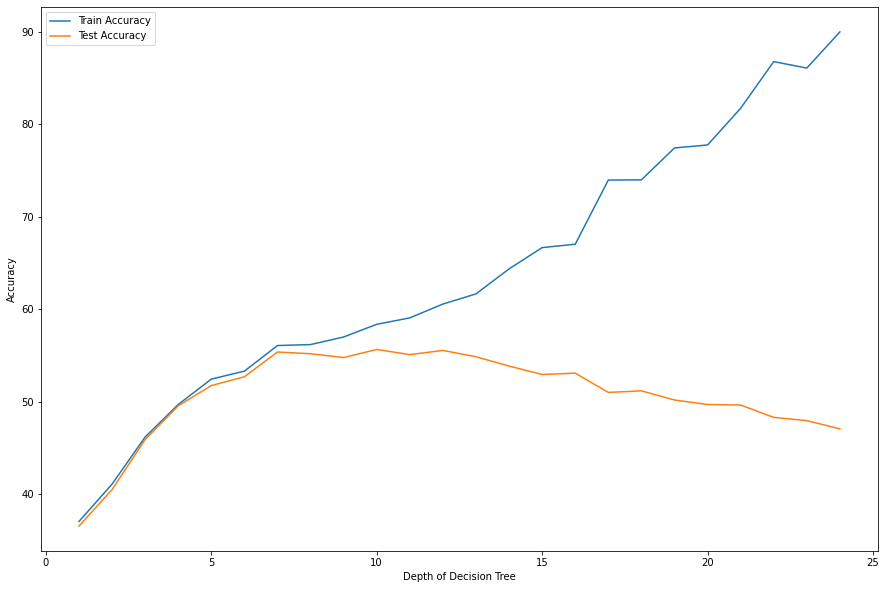

In [12]:
fig = plt.figure(figsize=(15, 10))
plt.plot(depths,accuracies_train,label='Train Accuracy')
plt.plot(depths,accuracies_test,label='Test Accuracy')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Entropy Impurity for p3 in A1

In [13]:
depths=list(range(1,40))
accuracies_train=[]
accuracies_test=[]
for i in depths:
    classifier = DecisionTreeClassifier(min_samples_split=2, maximum_depth=i,impurity='entropy')
    classifier.fit(Data_X_train,Data_Y_train)
    #classifier.print_tree()
    Y_pred = classifier.predict(Data_X_test)
    accuracy_test=get_accuracy(Y_pred,Data_Y_test)
    accuracies_test.append(accuracy_test)
    Y_pred_train = classifier.predict(Data_X_train)
    accuracy_train=get_accuracy(Y_pred_train,Data_Y_train)
    accuracies_train.append(accuracy_train)
    print("Depth:",i)
    print("Train Accuracy:",accuracy_train)
    print("Test Accuracy:",accuracy_test)

Depth: 1
Train Accuracy: 36.29833333333333
Test Accuracy: 35.88666666666667
Depth: 2
Train Accuracy: 41.623333333333335
Test Accuracy: 41.126666666666665
Depth: 3
Train Accuracy: 50.24999999999999
Test Accuracy: 49.980000000000004
Depth: 4
Train Accuracy: 49.901666666666664
Test Accuracy: 49.57333333333334
Depth: 5
Train Accuracy: 51.324999999999996
Test Accuracy: 50.9
Depth: 6
Train Accuracy: 53.845
Test Accuracy: 53.24666666666666
Depth: 7
Train Accuracy: 55.51666666666667
Test Accuracy: 54.986666666666665
Depth: 8
Train Accuracy: 56.38166666666666
Test Accuracy: 54.84
Depth: 9
Train Accuracy: 57.74
Test Accuracy: 55.68666666666666
Depth: 10
Train Accuracy: 58.096666666666664
Test Accuracy: 55.96666666666666
Depth: 11
Train Accuracy: 59.891666666666666
Test Accuracy: 55.166666666666664
Depth: 12
Train Accuracy: 60.565000000000005
Test Accuracy: 54.67999999999999
Depth: 13
Train Accuracy: 64.42666666666666
Test Accuracy: 53.82666666666667
Depth: 14
Train Accuracy: 65.915
Test Accuracy

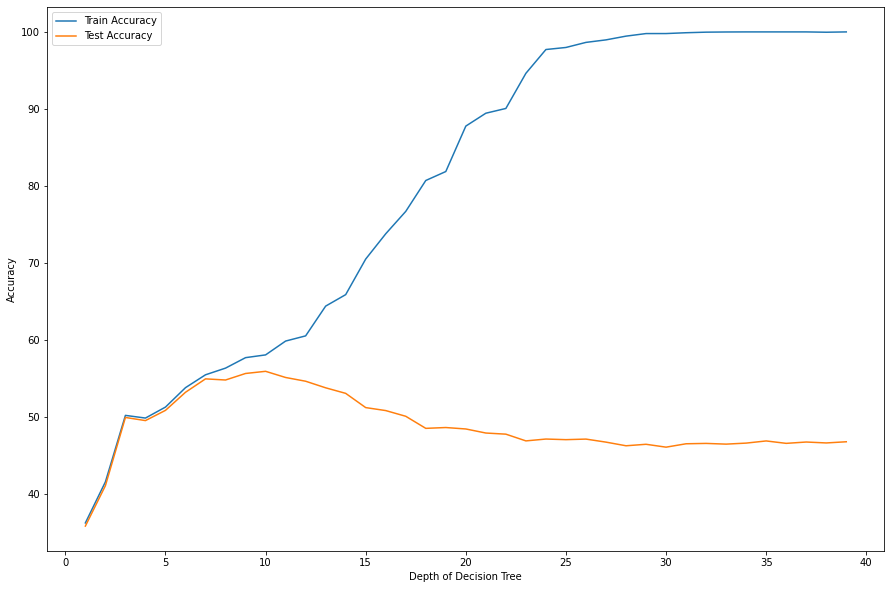

In [14]:
fig = plt.figure(figsize=(15, 10))
plt.plot(depths,accuracies_train,label='Train Accuracy')
plt.plot(depths,accuracies_test,label='Test Accuracy')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# p5

In [213]:
def get_train_test_split(csv_file,test_percent):
    with open(csv_file, 'r') as f:
        results = []
        next(f)
        for line in f:
            words = line.split(',')
            for i in range(len(words)):
                words[i] = float(words[i])
            results.append(words)
    Data = np.array(results)   
    
    val_size = test_percent/100
    # calculate the number of validation data rows
    val_rows = int(val_size * Data.shape[0])


    # split the data into train and validation sets
    Data_train = Data[val_rows:]
    Data_train=np.array(Data_train)
    Data_Y_train = Data_train[:,0].astype(int)
    Data_X_train = np.delete(Data_train, 0, axis = 1)
    #
    Data_val = Data[:val_rows]
    Data_val=np.array(Data_val)
    Data_Y_val = Data_val[:,0].astype(int)
    Data_X_val = np.delete(Data_val, 0, axis = 1)
    return Data_X_train,Data_Y_train,Data_X_val,Data_Y_val

In [214]:
Data_X_train,Data_Y_train,Data_X_test,Data_Y_test=get_train_test_split('PCA_MNIST.csv',30)

In [58]:
def minmaxNormalize(X):
    X_norm = np.zeros(X.shape)
    for i in range(0,X.shape[1]):
        if np.max(X[:,i]) != np.min(X[:,i]):
            X_norm[:,i] = (X[:,i] - np.min(X[:,i])) / (np.max(X[:,i]) - np.min(X[:,i]))
#         elif np.max(X[:,i] == np.min(X[:,i])):
#             X_norm[:,i] = np.ones(X_norm[:,i].shape)
    return X_norm

In [59]:
Data_X_train_norm=minmaxNormalize(Data_X_train)
Data_X_test_norm=minmaxNormalize(Data_X_test)

In [60]:
classifier = DecisionTreeClassifier(min_samples_split=3, maximum_depth=3,impurity='entropy')
classifier.fit(Data_X_train,Data_Y_train)
classifier.print_tree()

X_0 <= -188.65385519897404 ? 0.6219240440171228
 left:X_2 <= -7.1849920318258 ? 0.445249767302927
  left:X_1 <= -197.04076116159115 ? 0.5336773569529738
    left:X_5 <= 249.1904674294832 ? 0.37542980932512415
        left:6
        right:7
    right:X_9 <= 77.68171289855377 ? 0.25033552992817576
        left:3
        right:4
  right:X_4 <= 135.49174476748294 ? 0.46896554768631704
    left:X_5 <= 122.61667332904813 ? 0.2741830200457356
        left:6
        right:7
    right:X_2 <= 182.0013053911994 ? 0.4006787233935476
        left:7
        right:2
 right:X_3 <= -38.412780335765774 ? 0.5190018176505546
  left:X_1 <= 2.1340879560511894 ? 0.5475508762742964
    left:X_1 <= -325.3737544680349 ? 0.39294843146869174
        left:0
        right:1
    right:X_1 <= 557.4295731593589 ? 0.7499826610168393
        left:9
        right:2
  right:X_2 <= -249.57884888157406 ? 0.5636521899163558
    left:X_7 <= 47.53159018157055 ? 0.3406419178226652
        left:4
        right:5
    right:X_1 <=

In [61]:
Y_pred = classifier.predict(Data_X_test)
metrics(Y_pred, Data_Y_test)

Classification Accuracy  on Test Data is:  68.43333333333334 

Confusion Matrix is: 
 [[1.299e+03 0.000e+00 6.000e+00 5.000e+00 3.100e+01 0.000e+00 1.000e+00
  7.400e+01 3.040e+02 8.000e+01]
 [2.200e+01 1.102e+03 3.000e+00 8.000e+00 4.020e+02 3.000e+00 4.400e+01
  8.800e+01 1.200e+02 8.000e+00]
 [9.500e+01 5.000e+00 1.212e+03 2.490e+02 2.500e+01 7.600e+01 2.300e+01
  7.900e+01 2.700e+01 9.000e+00]
 [2.300e+01 0.000e+00 3.500e+01 1.475e+03 1.040e+02 4.000e+00 0.000e+00
  1.310e+02 2.800e+01 0.000e+00]
 [0.000e+00 1.000e+00 4.600e+01 6.400e+01 1.595e+03 1.500e+01 4.000e+00
  4.300e+01 3.200e+01 0.000e+00]
 [5.000e+00 4.000e+00 1.300e+01 9.800e+01 2.400e+01 1.495e+03 1.340e+02
  2.000e+00 2.000e+01 5.000e+00]
 [4.700e+01 8.000e+00 3.000e+01 2.930e+02 3.000e+01 4.170e+02 9.240e+02
  2.500e+01 1.900e+01 7.000e+00]
 [7.800e+01 1.000e+00 0.000e+00 1.100e+01 3.150e+02 1.000e+00 0.000e+00
  1.376e+03 1.200e+01 6.000e+00]
 [4.610e+02 2.000e+00 1.100e+01 6.300e+01 1.470e+02 2.000e+01 7.000e+00
  

### Gini Impurity for p4 in A1

In [215]:
depths=list(range(1,25))
accuracies_train=[]
accuracies_test=[]
for i in depths:
    classifier = DecisionTreeClassifier(min_samples_split=3, maximum_depth=i,impurity='gini')
    classifier.fit(Data_X_train,Data_Y_train)
    #classifier.print_tree()
    Y_pred = classifier.predict(Data_X_test)
    accuracy_test=get_accuracy(Y_pred,Data_Y_test)
    accuracies_test.append(accuracy_test)
    Y_pred_train = classifier.predict(Data_X_train)
    accuracy_train=get_accuracy(Y_pred_train,Data_Y_train)
    accuracies_train.append(accuracy_train)
    print("Depth:",i)
    print("Train Accuracy:",accuracy_train)
    print("Test Accuracy:",accuracy_test)

Depth: 1
Train Accuracy: 32.76904761904762
Test Accuracy: 28.12777777777778
Depth: 2
Train Accuracy: 47.04047619047619
Test Accuracy: 41.422222222222224
Depth: 3
Train Accuracy: 65.8404761904762
Test Accuracy: 58.116666666666674
Depth: 4
Train Accuracy: 79.33571428571429
Test Accuracy: 72.50555555555556
Depth: 5
Train Accuracy: 83.47142857142858
Test Accuracy: 76.66666666666667
Depth: 6
Train Accuracy: 86.07142857142858
Test Accuracy: 79.12777777777778
Depth: 7
Train Accuracy: 88.51190476190476
Test Accuracy: 81.96111111111111
Depth: 8
Train Accuracy: 91.07380952380953
Test Accuracy: 83.17222222222223
Depth: 9
Train Accuracy: 92.50714285714285
Test Accuracy: 83.75
Depth: 10
Train Accuracy: 94.6595238095238
Test Accuracy: 84.72777777777777
Depth: 11
Train Accuracy: 95.99285714285715
Test Accuracy: 85.45555555555555
Depth: 12
Train Accuracy: 97.02857142857142
Test Accuracy: 85.95555555555555
Depth: 13
Train Accuracy: 97.69761904761904
Test Accuracy: 85.63333333333333
Depth: 14
Train Accu

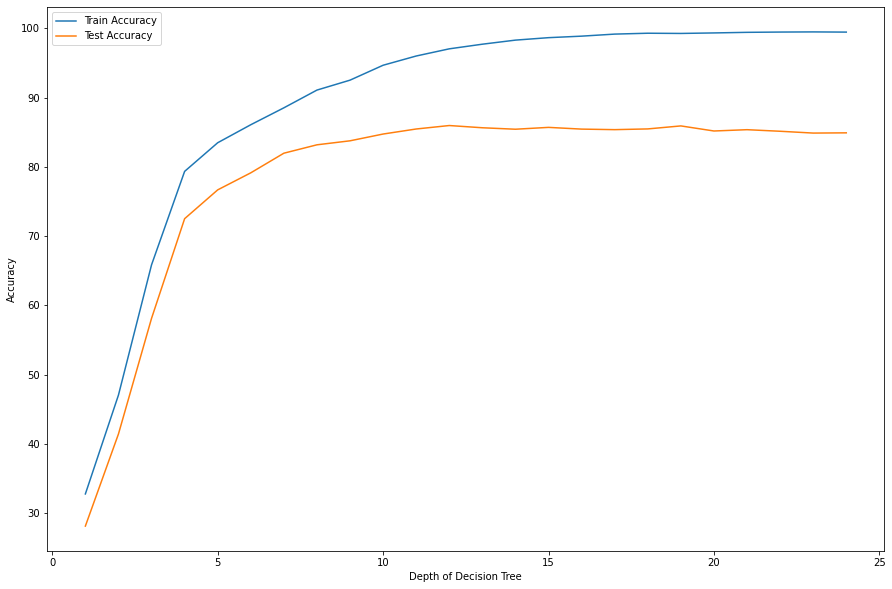

In [216]:
fig = plt.figure(figsize=(15, 10))
plt.plot(depths,accuracies_train,label='Train Accuracy')
plt.plot(depths,accuracies_test,label='Test Accuracy')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Entropy Impurity for p4 in A1

In [217]:
depths=list(range(1,40))
accuracies_train=[]
accuracies_test=[]
for i in depths:
    classifier = DecisionTreeClassifier(min_samples_split=2, maximum_depth=i,impurity='entropy')
    classifier.fit(Data_X_train,Data_Y_train)
    #classifier.print_tree()
    Y_pred = classifier.predict(Data_X_test)
    accuracy_test=get_accuracy(Y_pred,Data_Y_test)
    accuracies_test.append(accuracy_test)
    Y_pred_train = classifier.predict(Data_X_train)
    accuracy_train=get_accuracy(Y_pred_train,Data_Y_train)
    accuracies_train.append(accuracy_train)
    print("Depth:",i)
    print("Train Accuracy:",accuracy_train)
    print("Test Accuracy:",accuracy_test)

Depth: 1
Train Accuracy: 36.01190476190476
Test Accuracy: 34.35
Depth: 2
Train Accuracy: 55.19761904761905
Test Accuracy: 53.666666666666664
Depth: 3
Train Accuracy: 73.3047619047619
Test Accuracy: 68.55
Depth: 4
Train Accuracy: 81.95714285714286
Test Accuracy: 74.98333333333333
Depth: 5
Train Accuracy: 85.63333333333333
Test Accuracy: 79.12777777777778
Depth: 6
Train Accuracy: 87.83571428571429
Test Accuracy: 81.50555555555556
Depth: 7
Train Accuracy: 90.65952380952382
Test Accuracy: 83.73888888888888
Depth: 8
Train Accuracy: 92.7404761904762
Test Accuracy: 84.04444444444444
Depth: 9
Train Accuracy: 94.80714285714285
Test Accuracy: 84.95555555555555
Depth: 10
Train Accuracy: 96.3
Test Accuracy: 85.11666666666666
Depth: 11
Train Accuracy: 97.81904761904762
Test Accuracy: 85.73888888888888
Depth: 12
Train Accuracy: 98.39761904761905
Test Accuracy: 85.55
Depth: 13
Train Accuracy: 99.27380952380952
Test Accuracy: 85.66111111111111
Depth: 14
Train Accuracy: 99.53333333333333
Test Accuracy:

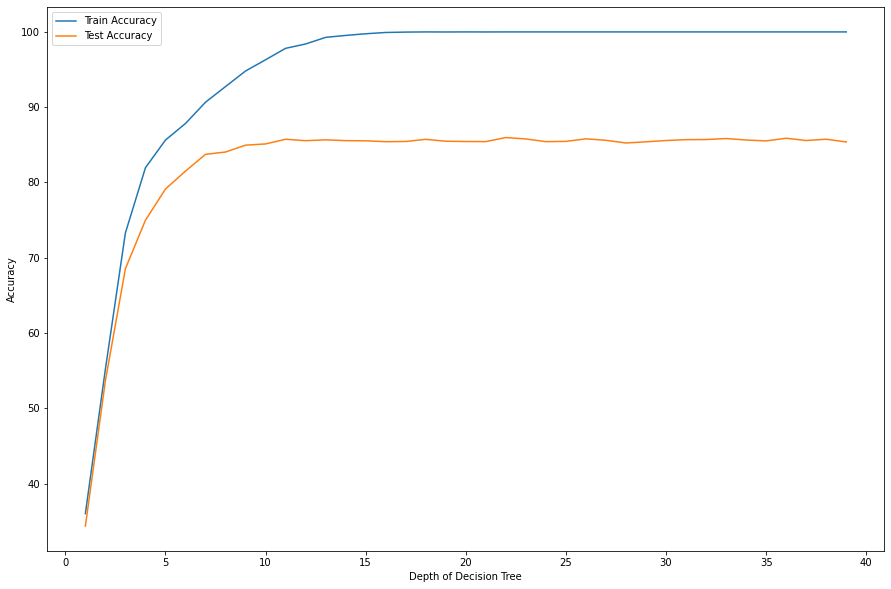

In [218]:
fig = plt.figure(figsize=(15, 10))
plt.plot(depths,accuracies_train,label='Train Accuracy')
plt.plot(depths,accuracies_test,label='Test Accuracy')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# RANDOM FORESTS

### PCA_MNIST

In [207]:
def get_random_forest_classifiers(number_of_trees,Data_X_train,Data_Y_train):
    classifiers=[]
    new_Data_X_train=[]
    new_Data_Y_train=[]
    dataset = np.concatenate((Data_X_train, Data_Y_train.reshape(-1,1)),axis=1)
    number_of_datasets=number_of_trees
    for i in range(number_of_datasets):
        print(i)
        new_Data_train=dataset[np.random.choice(dataset.shape[0], len(Data_X_train), replace=True)]
        new_Data_Y_train = new_Data_train[:,10].astype(int)
        new_Data_X_train = np.delete(new_Data_train, 10, axis = 1)
        #print(new_Data_Y_train)
        classifier = DecisionTreeClassifier(min_samples_split=3, maximum_depth=4)
        classifier.fit(new_Data_X_train,new_Data_Y_train)
        classifiers.append(classifier)
    return classifiers

In [ ]:
classifiers=get_random_forest_classifiers(20,Data_X_train,Data_Y_train)

In [209]:
def get_accuracy_scores(classifiers,Data_X_test,Data_Y_test):
    random_forest_accuracies_list=[]
    Y_predictions=[]
    i=0
    for classifier in classifiers:
        Y_pred=[]
        Y_predictions.append(classifier.predict(Data_X_test))
        #print(Y_predictions)
        for i in range(len(Data_X_test)):
            l=[]
            for j in range(len(Y_predictions)):
                l.append(Y_predictions[j][i])
            Y_pred.append(max(l,key=l.count))
    
        random_forest_accuracies_list.append(get_accuracy(Y_pred,Data_Y_test))
    return random_forest_accuracies_list
        

In [210]:
acc_scores=get_accuracy_scores(classifiers,Data_X_test,Data_Y_test)

In [211]:
print(acc_scores)

[70.91111111111111, 70.91111111111111, 72.5, 72.38888888888889, 72.78333333333333, 72.5611111111111, 72.86666666666667, 72.66111111111111, 73.16666666666667, 72.91666666666666, 73.36666666666667, 73.31111111111112, 73.43888888888888, 73.22777777777777, 73.28888888888889, 73.22777777777777, 73.2611111111111, 73.28333333333333, 73.21111111111111, 73.27777777777777]


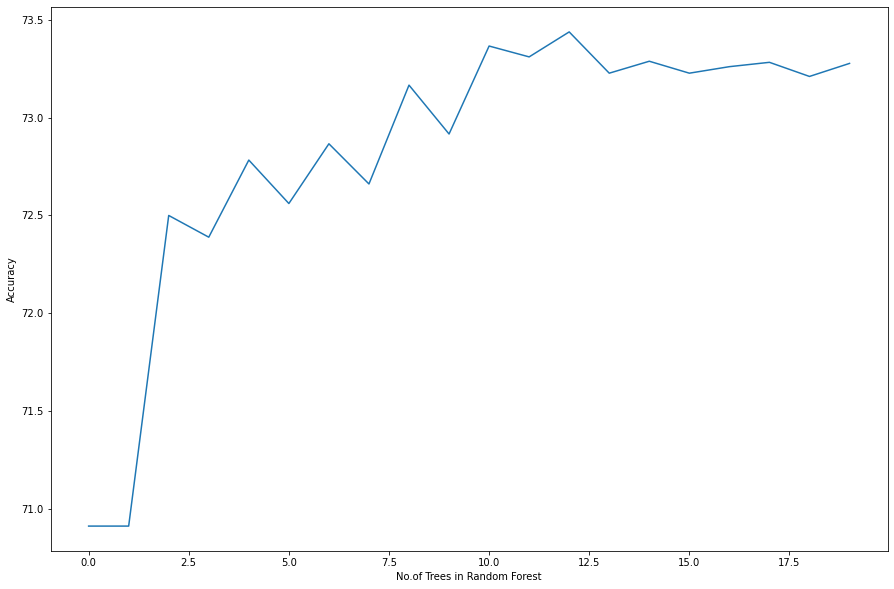

In [221]:
fig = plt.figure(figsize=(15, 10))
plt.plot(acc_scores)
plt.xlabel('No.of Trees in Random Forest')
plt.ylabel('Accuracy')
plt.show()

### p3

In [222]:
with open('p3_train.csv', 'r') as f:
    results = []
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)
Data = np.array(results)
Data_Y_train = Data[:,10].astype(int)
Data_Y_train=Data_Y_train.reshape(-1,1)
Data_X_train = np.delete(Data, 10, axis = 1)

In [223]:
with open('p3_test.csv', 'r') as f:
    results = []
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)
Data_test = np.array(results)
Data_Y_test = Data_test[:,10].astype(int)
Data_X_test = np.delete(Data_test, 10, axis = 1)

In [ ]:
classifiers_p3=get_random_forest_classifiers(20,Data_X_train,Data_Y_train)

In [225]:
acc_scores=get_accuracy_scores(classifiers_p3,Data_X_test,Data_Y_test)

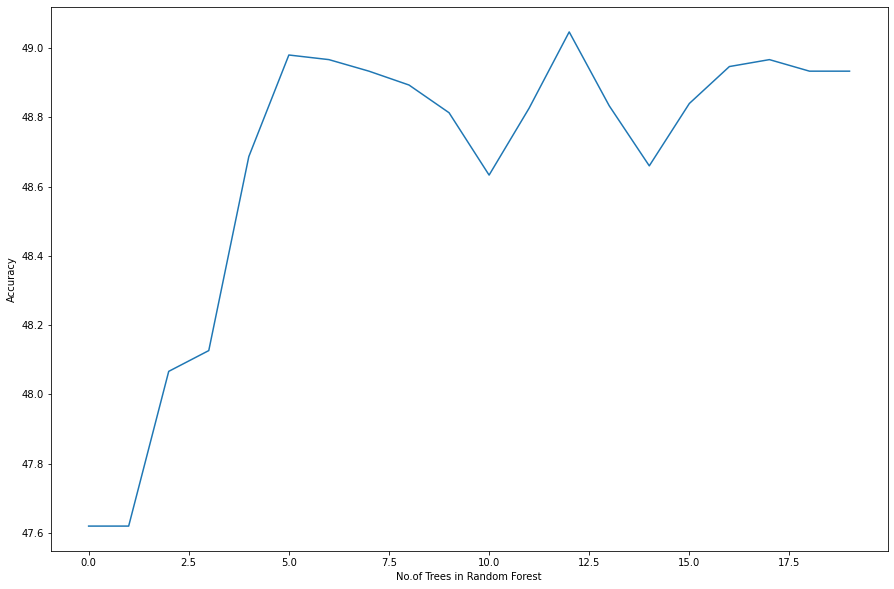

In [226]:
fig = plt.figure(figsize=(15, 10))
plt.plot(acc_scores)
plt.xlabel('No.of Trees in Random Forest')
plt.ylabel('Accuracy')
plt.show()

In [227]:
print(acc_scores)

[47.620000000000005, 47.620000000000005, 48.06666666666667, 48.126666666666665, 48.68666666666667, 48.980000000000004, 48.96666666666666, 48.93333333333334, 48.89333333333333, 48.81333333333333, 48.63333333333333, 48.82666666666667, 49.04666666666667, 48.833333333333336, 48.66, 48.84, 48.946666666666665, 48.96666666666666, 48.93333333333334, 48.93333333333334]
